# Prediction
Explanation:

## Import Packages

In [42]:
from importnb import Notebook
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, make_scorer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from imblearn.over_sampling import SMOTE
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import shap
from sklearn.calibration import calibration_curve
import seaborn as sns
import numpy as np

## Dataframe import from 'FeatureEngineering'

In [43]:
pd.set_option('display.max_columns', None)

In [44]:
#with Notebook():
#    from ModelPreparation import data


## Manual Upload

In [45]:
data = pd.read_csv('data.csv')

In [46]:
data

,ID,Number of Founders,Number of Employees,Number of Funding Rounds,Last Funding Amount,Total Funding Amount,Number of Lead Investors,Number of Investors,Number of Acquisitions,X: Followers,X: Following,X: Number of Tweets,X: Account Age Days,X: Tweet Activity,X: Followers Max Growth,X: Followers Max Loss,X: Tweets Max Growth,X: Tweets Max Loss,Months until First Round,Grant Y/N,Made Acquisitions,Project Funding,Startup Funding,Growth Funding,Expansion Funding,Exit Funding,Average Time To Next Round,Average Funding Size,Average Number of Investments by Investors,Average Number of Exits by Investors,Average Number of Lead Investments by Investors,Average Number of Portfolio Organizations by Investors,Investor Country_AUS,Investor Country_GER,Investor Country_SWI,Investor Country_UK,Investor Country_USA,Top Investor Participation,Industry_administrative services,Industry_advertising,Industry_agriculture and farming,Industry_apps,Industry_artificial intelligence (ai),Industry_biotechnology,Industry_blockchain and cryptocurrency,Industry_clothing and apparel,Industry_commerce and shopping,Industry_community and lifestyle,Industry_consumer electronics,Industry_consumer goods,Industry_content and publishing,Industry_data and analytics,Industry_design,Industry_education,Industry_energy,Industry_events,Industry_financial services,Industry_food and beverage,Industry_gaming,Industry_government and military,Industry_hardware,Industry_health care,Industry_information technology,Industry_internet services,Industry_lending and investments,Industry_manufacturing,Industry_media and entertainment,Industry_messaging and telecommunications,Industry_mobile,Industry_music and audio,Industry_natural resources,Industry_navigation and mapping,Industry_other,Industry_payments,Industry_platforms,Industry_privacy and security,Industry_professional services,Industry_real estate,Industry_sales and marketing,Industry_science and engineering,Industry_social impact,Industry_software,Industry_sports,Industry_sustainability,Industry_transportation,Industry_travel and tourism,Industry_video,LinkedIn: Average Followers Founders,LinkedIn: Average Connections Founders,LinkedIn: Min Followers Founders,LinkedIn: Max Followers Founders,LinkedIn: Min Connections Founders,LinkedIn: Max Connections Founders,Highest Education Bachelor,Highest Education Doctor/PhD,Highest Education Master,International Team,Top University,Studies Abroad Founder,Firsttime Founder Ratio,All Firsttime Founders,Any Firsttime Founder,Researcher Ratio,All Researchers,Any Researcher,Executive Ratio,All Executives,Any Executive,Few Years Experience Ratio,Decade Experience Ratio,Mid Career Experience Ratio,Avg Gaps in Experience,Avg Longest Position Duration,Success
0,1,1.0000,30.5000,2,7000000.0000,7000000.0000,3.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,40.0000,0,0,1,1,0,0,0,31.5500,7000000.0000,0.0000,182.0000,220.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,4815.0000,3914.0000,4815.0000,4815.0000,3914.0000,3914.0000,0.0000,0.0000,1.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,150.1667,0
1,2,2.0000,30.5000,2,3000000.0000,3000000.0000,1.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,15.0000,0,0,1,1,0,0,0,16.4333,3000000.0000,321.0000,32.0000,49.5000,277.0000,0.0000,1.0000,0.0000,0.0000,1.0000,1,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0

## Train-Test-Split

In [47]:
ID = data['ID']
X = data.drop(columns=['Success', 'ID'])
y = data['Success']

# Train-Test Split
X_train, X_test, y_train, y_test, ID_train, ID_test = train_test_split(
    X, y, ID, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE on the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

additional_ids = len(y_train_resampled) - len(ID_train)

new_ids = np.arange(len(ID_train), len(ID_train) + additional_ids)

ID_train_resampled = np.concatenate([ID_train, new_ids])

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

## Models

### Logistic Regression

In [48]:
# Logistic Regression
warnings.filterwarnings("ignore", category=FutureWarning) # No influence on the result and just for a cleaner output
warnings.filterwarnings("ignore", category=UserWarning) # No influence on the result and just for a cleaner output
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train_scaled, y_train_resampled)
logistic_predictions = logistic_model.predict(X_test_scaled)
logistic_proba = logistic_model.predict_proba(X_test_scaled)[:, 1]
logistic_auc = roc_auc_score(y_test, logistic_proba)
logistic_report = classification_report(y_test, logistic_predictions, output_dict=True)

print('Test AUC:', logistic_auc)
print('Classification Report:')
print(classification_report(y_test, logistic_predictions))

Test AUC: 0.7910131090399333
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.76      0.84       249
           1       0.39      0.70      0.50        53

    accuracy                           0.75       302
   macro avg       0.65      0.73      0.67       302
weighted avg       0.83      0.75      0.78       302



### Gradient Boosting

In [49]:
# Gradient Boosting
# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.03, 0.035],  
    'n_estimators': [400, 450],  
    'max_depth': [5, 6],  
    'min_samples_split': [8, 10],  
    'min_samples_leaf': [6, 7],  
    'subsample': [0.6, 0.7],  
    'max_features': ['sqrt', 'log2'],  
}

# Initialize the Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)

# Define the scoring metric
scorer = make_scorer(roc_auc_score, needs_proba=True)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=10,  # Stratified K-Fold Cross-Validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV to the data
grid_search.fit(X_train_scaled, y_train_resampled)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)

# Evaluate the best model on the test set
best_gb_model = grid_search.best_estimator_
test_predictions = best_gb_model.predict(X_test_scaled)
test_auc = roc_auc_score(y_test, best_gb_model.predict_proba(X_test_scaled)[:, 1])

print("Test AUC Score:", test_auc)
print("Classification Report on Test Set:")
print(classification_report(y_test, test_predictions))

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
Best Parameters: {'learning_rate': 0.03, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 8, 'n_estimators': 400, 'subsample': 0.6}
Test AUC Score: 0.8277638857316056
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       249
           1       0.72      0.55      0.62        53

    accuracy                           0.88       302
   macro avg       0.82      0.75      0.78       302
weighted avg       0.88      0.88      0.88       302



### LightGBM

In [50]:
# LightGBM
# Define the hyperparameter grid for LightGBM
param_grid_lgb = {
    'learning_rate': [0.02, 0.025],          
    'n_estimators': [300, 350],             
    'min_child_samples': [4, 6, 8],        
    'num_leaves': [15, 20],                 
    'subsample': [0.5, 0.55],               
    'colsample_bytree': [0.6],             
    'reg_alpha': [0.5, 1.0],                
    'reg_lambda': [3.0],                   
    'scale_pos_weight': [1.0, 1.5, 2.0],    
}
# Initialize the LightGBM Classifier
lgb_model = LGBMClassifier(random_state=42)

# Set up GridSearchCV for LightGBM
grid_search_lgb = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid_lgb,
    scoring=scorer,  # Use AUC as the scoring metric
    cv=5,  
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV to the data
grid_search_lgb.fit(X_train_scaled, y_train_resampled)

# Get the best parameters and score for LightGBM
best_params_lgb = grid_search_lgb.best_params_
best_score_lgb = grid_search_lgb.best_score_

print("Best Parameters (LightGBM):", best_params_lgb)

# Evaluate the best LightGBM model on the test set
best_lgb_model = grid_search_lgb.best_estimator_
lgb_predictions = best_lgb_model.predict(X_test_scaled)
lgb_proba = best_lgb_model.predict_proba(X_test_scaled)[:, 1]
lgb_test_auc = roc_auc_score(y_test, lgb_proba)

print("Test AUC Score (LightGBM):", lgb_test_auc)
print("Classification Report (LightGBM):\n", classification_report(y_test, lgb_predictions))

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[LightGBM] [Info] Number of positive: 997, number of negative: 997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12978
[LightGBM] [Info] Number of data points in the train set: 1994, number of used features: 112
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best Parameters (LightGBM): {'colsample_bytree': 0.6, 'learning_rate': 0.02, 'min_child_samples': 4, 'n_estimators': 300, 'num_leaves': 15, 'reg_alpha': 0.5, 'reg_lambda': 3.0, 'scale_pos_weight': 1.0, 'subsample': 0.5}
Test AUC Score (LightGBM): 0.8432977191786012
Classification Report (LightGBM):
               precision    recall  f1-score   support

           0       0.91      0.96      0.93       249
           1       0.74   

### Neural Network

In [51]:
# Neural Network
nn_model = Sequential([
    Dense(256, kernel_regularizer=regularizers.l2(0.01), input_dim=X_train_scaled.shape[1], kernel_initializer=HeNormal(seed=42)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.1),

    Dense(128, kernel_regularizer=regularizers.l2(0.01), kernel_initializer=HeNormal(seed=42)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.1),

    Dense(64, kernel_regularizer=regularizers.l2(0.01), kernel_initializer=HeNormal(seed=42)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.1),

    Dense(32, kernel_regularizer=regularizers.l2(0.01), kernel_initializer=HeNormal(seed=42)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.1),

    Dense(1, activation='sigmoid', kernel_initializer=HeNormal(seed=42))
])

# Compile the model
nn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# Train the model with class weights
class_weights = {0: 1.0, 1: 3.0}
nn_model.fit(X_train_scaled, y_train_resampled, epochs=100, batch_size=32, verbose=0, shuffle=False, class_weight=class_weights)

# Predictions with optimized threshold
y_probs = nn_model.predict(X_test_scaled).flatten()
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_nn = thresholds[optimal_idx]

nn_predictions = (y_probs > optimal_threshold_nn).astype(int)
nn_report = classification_report(y_test, nn_predictions, output_dict=True)

# Evaluation
print("Optimal Threshold:", optimal_threshold_nn)
print("Test AUC Score (Neural Network):", roc_auc_score(y_test, y_probs))
print("Classification Report (Neural Network):\n", classification_report(y_test, nn_predictions))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Optimal Threshold: 0.6471944
Test AUC Score (Neural Network): 0.7462302038342047
Classification Report (Neural Network):
               precision    recall  f1-score   support

           0       0.90      0.89      0.89       249
           1       0.50      0.51      0.50        53

    accuracy                           0.82       302
   macro avg       0.70      0.70      0.70       302
weighted avg       0.83      0.82      0.83       302



### Weighted Ensemble

In [52]:
# Weighted Ensemble 
ensemble_proba_weighted = (
    0.35 * best_gb_model.predict_proba(X_test_scaled)[:, 1] +
    0.35 * best_lgb_model.predict_proba(X_test_scaled)[:, 1] +
    0.3 * nn_model.predict(X_test_scaled).flatten() +
    0.0 * logistic_model.predict_proba(X_test_scaled)[:, 1]
)

# Optimize Threshold for Weighted Ensemble
precision, recall, thresholds = precision_recall_curve(y_test, ensemble_proba_weighted)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = f1_scores.argmax()
optimal_threshold = thresholds[optimal_idx]

ensemble_predictions_weighted = (ensemble_proba_weighted > optimal_threshold).astype(int)

# Evaluation des Weighted Ensembles
ensemble_auc_weighted = roc_auc_score(y_test, ensemble_proba_weighted)
ensemble_report_weighted = classification_report(y_test, ensemble_predictions_weighted)

print("Optimized Weighted Ensemble Test AUC Score:", ensemble_auc_weighted)
print("Optimal Threshold for Weighted Ensemble:", optimal_threshold)
print("Classification Report (Optimized Weighted Ensemble):\n", ensemble_report_weighted)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Optimized Weighted Ensemble Test AUC Score: 0.8167007653254528
Optimal Threshold for Weighted Ensemble: 0.5442574159209108
Classification Report (Optimized Weighted Ensemble):
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       249
           1       0.78      0.55      0.64        53

    accuracy                           0.89       302
   macro avg       0.85      0.76      0.79       302
weighted avg       0.89      0.89      0.89       302



### Add TabPFN classifier results from Modelling_tabpfn.py

In [53]:
# To load the predictions

loaded_predictions_tabpfn = pd.read_csv('tabpfn_predictions.csv')

### Add LLM results

In [54]:
results_LLM = pd.read_csv('llm_predictions_results_f1optim.csv')

labels_llm = results_LLM['actual_label']
predictions_llm = results_LLM['predicted_label']
y_probs_llm = results_LLM['success_probability']


report_llm = classification_report(labels_llm, predictions_llm, target_names=["No-Success", "Success"], output_dict=True)

### Results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
                 Model  Accuracy  Precision  Recall  F1-Score    AUC
0    Gradient Boosting    0.8841     0.8167  0.7515    0.7776 0.8278
1             LightGBM    0.8841     0.8211  0.7441    0.7736 0.8433
2       Neural Network    0.8245     0.6976  0.7005    0.6990 0.7462
3  Logistic Regression    0.7517     0.6539  0.7306    0.6659 0.7910
4    Weighted Ensemble    0.8940     0.8466  0.7575    0.7911 0.8167
5               TabPFN    0.9073     0.9324  0.7433    0.7983 0.8479
6       distilBERT LLM    0.9255     0.9273  0.8063    0.8511 0.8919
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


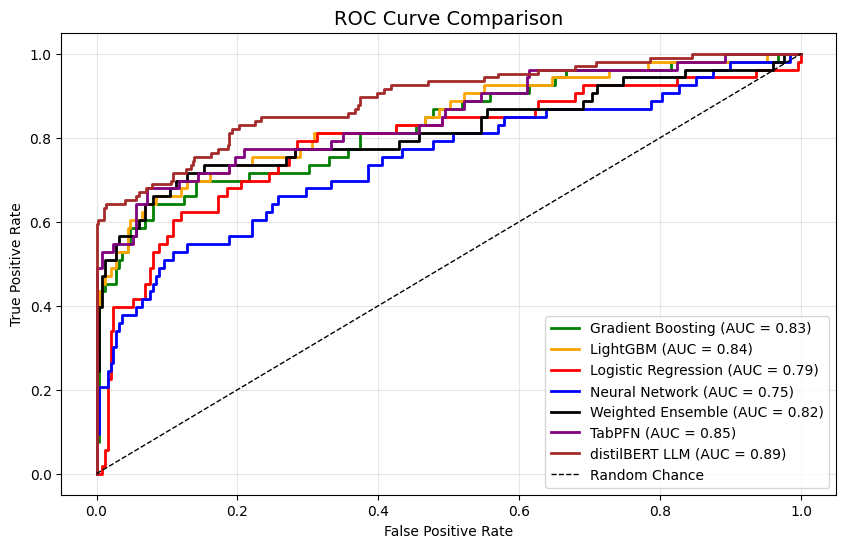

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


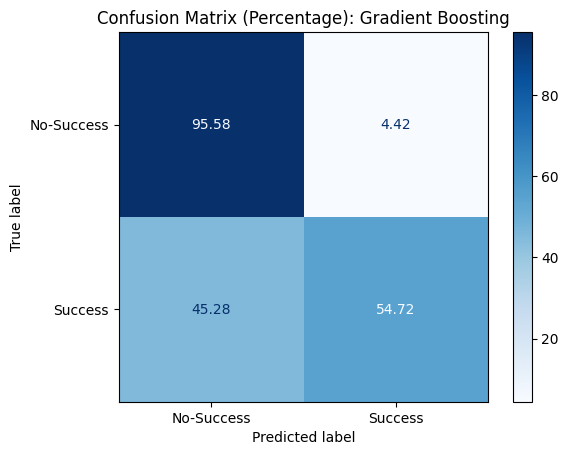

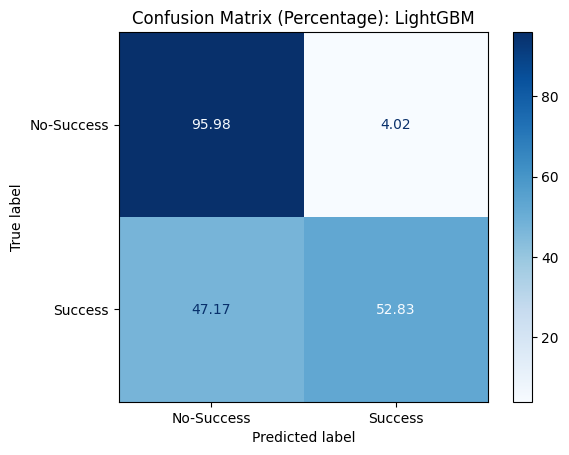

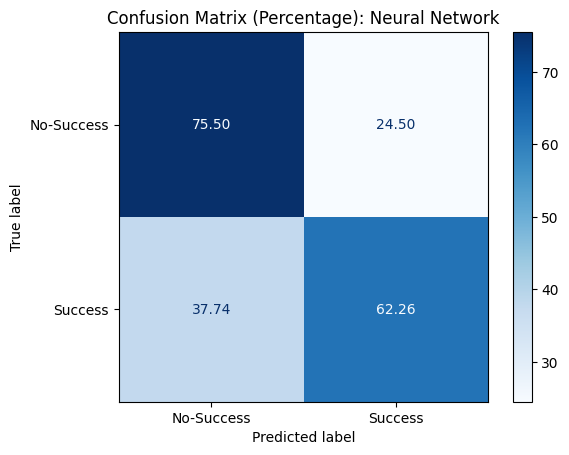

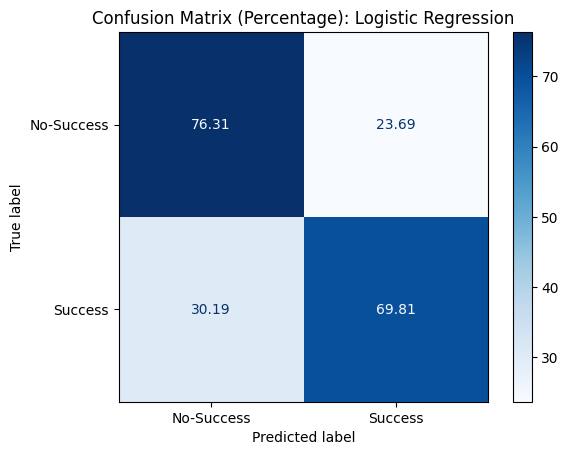

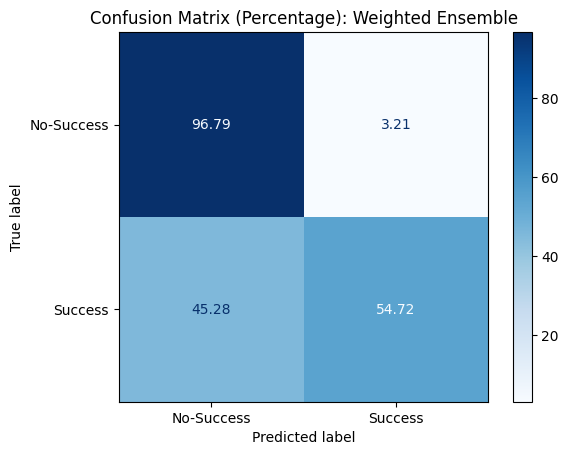

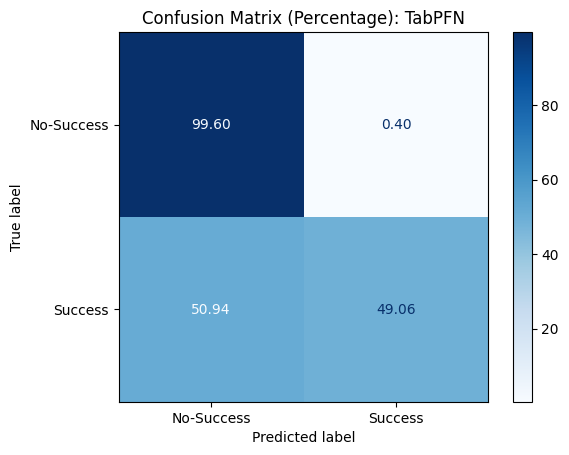

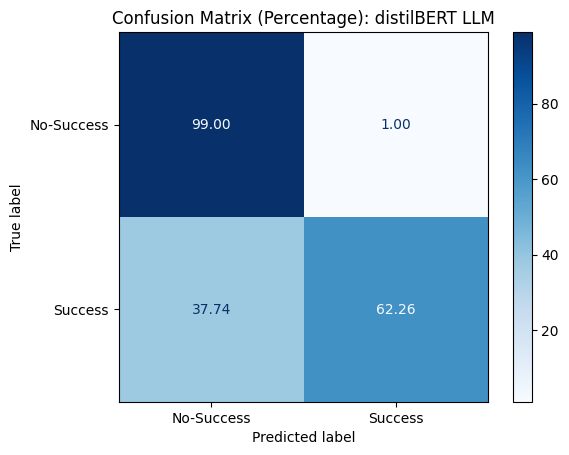

In [55]:
### Results
# Results Comparison
results = {
    "Model": ["Gradient Boosting", "LightGBM", "Neural Network", "Logistic Regression", "Weighted Ensemble", "TabPFN", "distilBERT LLM"],
    "Accuracy": [
        classification_report(y_test, best_gb_model.predict(X_test_scaled), output_dict=True)['accuracy'],
        classification_report(y_test, best_lgb_model.predict(X_test_scaled), output_dict=True)['accuracy'],
        nn_report['accuracy'],
        logistic_report['accuracy'],
        classification_report(y_test, ensemble_predictions_weighted, output_dict=True)['accuracy'],
        classification_report(y_test, loaded_predictions_tabpfn["Predicted"], output_dict=True)['accuracy'],
        report_llm["accuracy"]
    ],
    "Precision": [
        classification_report(y_test, best_gb_model.predict(X_test_scaled), output_dict=True)['macro avg']['precision'],
        classification_report(y_test, best_lgb_model.predict(X_test_scaled), output_dict=True)['macro avg']['precision'],
        nn_report['macro avg']['precision'],
        logistic_report['macro avg']['precision'],
        classification_report(y_test, ensemble_predictions_weighted, output_dict=True)['macro avg']['precision'],
        classification_report(y_test, loaded_predictions_tabpfn["Predicted"], output_dict=True)['macro avg']['precision'],
        report_llm["macro avg"]["precision"]
    ],
    "Recall": [
        classification_report(y_test, best_gb_model.predict(X_test_scaled), output_dict=True)['macro avg']['recall'],
        classification_report(y_test, best_lgb_model.predict(X_test_scaled), output_dict=True)['macro avg']['recall'],
        nn_report['macro avg']['recall'],
        logistic_report['macro avg']['recall'],
        classification_report(y_test, ensemble_predictions_weighted, output_dict=True)['macro avg']['recall'],
        classification_report(y_test, loaded_predictions_tabpfn["Predicted"], output_dict=True)['macro avg']['recall'],
        report_llm["macro avg"]["recall"]
    ],
    "F1-Score": [
        classification_report(y_test, best_gb_model.predict(X_test_scaled), output_dict=True)['macro avg']['f1-score'],
        classification_report(y_test, best_lgb_model.predict(X_test_scaled), output_dict=True)['macro avg']['f1-score'],
        nn_report['macro avg']['f1-score'],
        logistic_report['macro avg']['f1-score'],
        classification_report(y_test, ensemble_predictions_weighted, output_dict=True)['macro avg']['f1-score'],
        classification_report(y_test, loaded_predictions_tabpfn["Predicted"], output_dict=True)['macro avg']['f1-score'],
        report_llm["macro avg"]["f1-score"]
    ],
    "AUC": [
        roc_auc_score(y_test, best_gb_model.predict_proba(X_test_scaled)[:, 1]),
        roc_auc_score(y_test, best_lgb_model.predict_proba(X_test_scaled)[:, 1]),
        roc_auc_score(y_test, nn_model.predict(X_test_scaled).ravel()),
        logistic_auc,
        roc_auc_score(y_test, ensemble_proba_weighted),
        roc_auc_score(y_test, loaded_predictions_tabpfn["Probability"]),
        roc_auc_score(labels_llm, y_probs_llm)
    ]
}

results_df = pd.DataFrame(results)
print(results_df)

# Plotting ROC Curve
plt.figure(figsize=(10, 6))
for model, name, color in zip([best_gb_model, best_lgb_model, logistic_model],
                              ["Gradient Boosting", "LightGBM", "Logistic Regression"],
                              ["green", "orange", "red"]):
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})', linewidth=2, color=color)

# Add Neural Network to ROC Curve
nn_pred_proba = nn_model.predict(X_test_scaled).ravel()
fpr, tpr, _ = roc_curve(y_test, nn_pred_proba)
auc = roc_auc_score(y_test, nn_pred_proba)
plt.plot(fpr, tpr, label=f'Neural Network (AUC = {auc:.2f})', linewidth=2, color='blue')

# Add Weighted Ensemble to ROC Curve
fpr, tpr, _ = roc_curve(y_test, ensemble_proba_weighted)
auc = roc_auc_score(y_test, ensemble_proba_weighted)
plt.plot(fpr, tpr, label=f'Weighted Ensemble (AUC = {auc:.2f})', linewidth=2, color='black')

# Add TabPFN to ROC Curve
fpr, tpr, _ = roc_curve(y_test, loaded_predictions_tabpfn["Probability"])
auc = roc_auc_score(y_test, loaded_predictions_tabpfn["Probability"])
plt.plot(fpr, tpr, label=f'TabPFN (AUC = {auc:.2f})', linewidth=2, color='purple')

# Add distilBERT LLM to ROC Curve
fpr, tpr, _ = roc_curve(labels_llm, y_probs_llm)
auc = roc_auc_score(labels_llm, y_probs_llm)
plt.plot(fpr, tpr, label=f'distilBERT LLM (AUC = {auc:.2f})', linewidth=2, color='brown')

# Add Baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Predictions
models = [
    ("Gradient Boosting", best_gb_model, best_gb_model.predict(X_test_scaled)),
    ("LightGBM", best_lgb_model, best_lgb_model.predict(X_test_scaled)),
    ("Neural Network", nn_model, (nn_model.predict(X_test_scaled) > optimal_threshold).astype(int)),
    ("Logistic Regression", logistic_model, logistic_predictions),
    ("Weighted Ensemble", None, ensemble_predictions_weighted),  # None for model since it's a manual ensemble
    ("TabPFN", None, loaded_predictions_tabpfn["Predicted"])  # None for model since it's externally computed due to computation constraints
]

for name, model, predictions in models:
    # Calculate confusion matrix and normalize to percentage
    cm = confusion_matrix(y_test, predictions)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Display confusion matrix
    cmd = ConfusionMatrixDisplay(cm_percentage, display_labels=["No-Success", "Success"])
    cmd.plot(cmap=plt.cm.Blues, values_format=".2f")
    plt.title(f"Confusion Matrix (Percentage): {name}")
    plt.show()

# confusion matrix for distilBERT LLM
cm_llm = confusion_matrix(labels_llm, predictions_llm)
cm_percentage_llm = cm_llm.astype('float') / cm_llm.sum(axis=1)[:, np.newaxis] * 100

cmd_llm = ConfusionMatrixDisplay(cm_percentage_llm, display_labels=["No-Success", "Success"])
cmd_llm.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title("Confusion Matrix (Percentage): distilBERT LLM")
plt.show()



## Model Probabilities Predictions

In [56]:
pd.options.display.float_format = '{:.4f}'.format  # Ensure non-scientific number formatting
gb_train_probabilities = best_gb_model.predict_proba(X_train_scaled)[:, 1]
gb_train_predictions = best_gb_model.predict(X_train_scaled)

gb_test_probabilities = best_gb_model.predict_proba(X_test_scaled)[:, 1]
gb_test_predictions = best_gb_model.predict(X_test_scaled)

# LightGBM
lgb_train_probabilities = best_lgb_model.predict_proba(X_train_scaled)[:, 1]
lgb_train_predictions = best_lgb_model.predict(X_train_scaled)

lgb_test_probabilities = best_lgb_model.predict_proba(X_test_scaled)[:, 1]
lgb_test_predictions = best_lgb_model.predict(X_test_scaled)

# Neural Network
nn_train_probabilities = nn_model.predict(X_train_scaled).ravel()
nn_train_predictions = (nn_train_probabilities > optimal_threshold_nn).astype(int)

nn_test_probabilities = nn_model.predict(X_test_scaled).ravel()
nn_test_predictions = (nn_test_probabilities > optimal_threshold_nn).astype(int)

# Logistic Regression
logistic_train_probabilities = logistic_model.predict_proba(X_train_scaled)[:, 1]
logistic_train_predictions = logistic_model.predict(X_train_scaled)

logistic_test_probabilities = logistic_model.predict_proba(X_test_scaled)[:, 1]
logistic_test_predictions = logistic_model.predict(X_test_scaled)

# TabPFN
tabpfn_test_probabilities = loaded_predictions_tabpfn["Probability"]
tabpfn_test_predictions = loaded_predictions_tabpfn["Predicted"]

# DistilBERT LLM
llm_test_probabilities = y_probs_llm
llm_test_predictions = predictions_llm

# Weighted Ensemble for training data
ensemble_train_probabilities = (
        0.35 * gb_train_probabilities +
        0.35 * lgb_train_probabilities +
        0.3 * nn_train_probabilities
)
ensemble_train_predictions = (ensemble_train_probabilities > optimal_threshold).astype(int)

# Weighted Ensemble for test data
ensemble_test_probabilities = (
        0.35 * gb_test_probabilities +
        0.35 * lgb_test_probabilities +
        0.3 * nn_test_probabilities
)
ensemble_test_predictions = (ensemble_test_probabilities > optimal_threshold).astype(int)

training_results = pd.DataFrame({
    "Observation Index": range(len(X_train_scaled)),
    "ID": ID_train_resampled,
    "True Class (Train)": y_train_resampled.values,
    "GB Prediction (Train)": gb_train_predictions,
    "GB Probability (Success, Train)": gb_train_probabilities,
    "LGB Prediction (Train)": lgb_train_predictions,
    "LGB Probability (Success, Train)": lgb_train_probabilities,
    "NN Prediction (Train)": nn_train_predictions,
    "NN Probability (Success, Train)": nn_train_probabilities,
    "Logistic Prediction (Train)": logistic_train_predictions,
    "Logistic Probability (Success, Train)": logistic_train_probabilities,
    "Ensemble Prediction (Train)": ensemble_train_predictions,
    "Ensemble Probability (Success, Train)": ensemble_train_probabilities,
})

# Create test results DataFrame
test_results = pd.DataFrame({
    "Observation Index": range(len(X_test_scaled)),
    "ID": ID_test.values,
    "True Class (Test)": y_test.values,
    "GB Prediction (Test)": gb_test_predictions,
    "GB Probability (Success, Test)": gb_test_probabilities,
    "LGB Prediction (Test)": lgb_test_predictions,
    "LGB Probability (Success, Test)": lgb_test_probabilities,
    "NN Prediction (Test)": nn_test_predictions,
    "NN Probability (Success, Test)": nn_test_probabilities,
    "Logistic Prediction (Test)": logistic_test_predictions,
    "Logistic Probability (Success, Test)": logistic_test_probabilities,
    "Ensemble Prediction (Test)": ensemble_test_predictions,
    "Ensemble Probability (Success, Test)": ensemble_test_probabilities,
    "TabPFN Prediction (Test)": tabpfn_test_predictions,
    "TabPFN Probability (Success, Test)": tabpfn_test_probabilities
})

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [57]:
test_results

,Observation Index,ID,True Class (Test),GB Prediction (Test),"GB Probability (Success, Test)",LGB Prediction (Test),"LGB Probability (Success, Test)",NN Prediction (Test),"NN Probability (Success, Test)",Logistic Prediction (Test),"Logistic Probability (Success, Test)",Ensemble Prediction (Test),"Ensemble Probability (Success, Test)",TabPFN Prediction (Test),"TabPFN Probability (Success, Test)"
0,0,732,0,0,0.0714,0,0.1652,0,0.5199,0,0.4354,0,0.2388,0,0.1125
1,1,37,1,0,0.0947,0,0.0707,0,0.4723,1,0.5796,0,0.1996,0,0.0365
2,2,408,0,0,0.0669,0,0.0538,0,0.5897,0,0.1860,0,0.2191,0,0.0339
3,3,784,0,0,0.0704,0,0.1001,1,0.7819,0,0.2957,0,0.2942,0,0.0602
4,4,135,0,0,0.0440,0,0.0499,0,0.4134,0,0.0418,0,0.1569,0,0.0165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,297,188,0,0,0.0473,0,0.0651,0,0.4162,0,0.1560,0,0.1642,0,0.0470
298,298,882,0,0,0.0181,0,0.0409,0,0.5266,0,0.1721,0,0.1786,0,0.0170
299,299,1318,0,0,0.0302,0,0.0298,0,0.3320,0,0.2247,0,0.1206,0,0.0274
300,300,335,0,0,0.0247,0,0.0537,0,0.3017,0,0.1818,0,0.1179,0,0.0247


## Visualizations

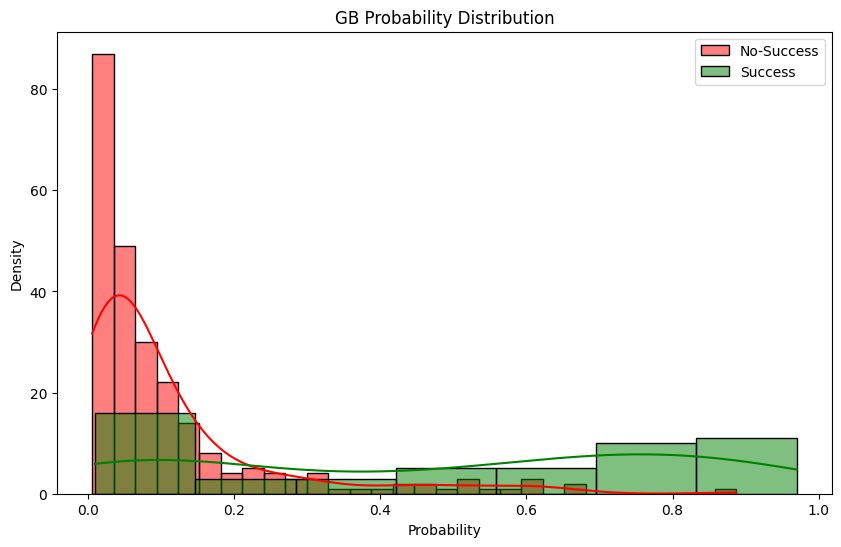

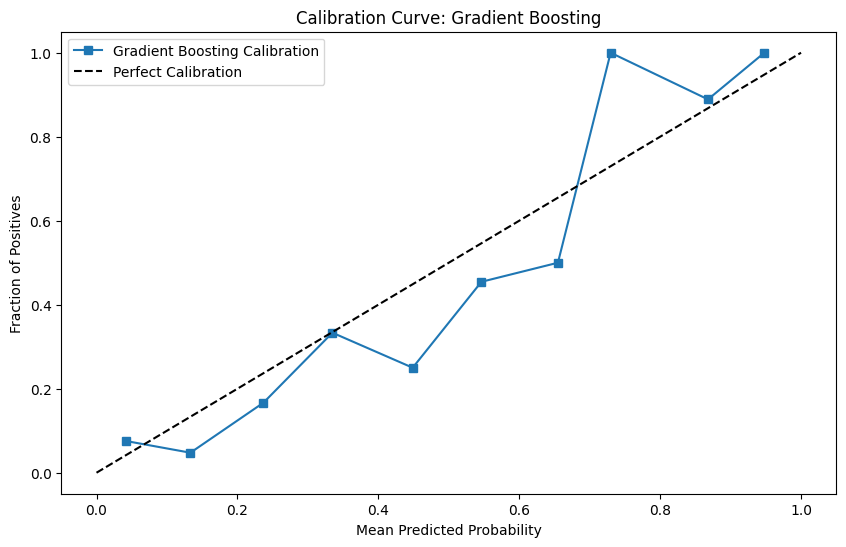

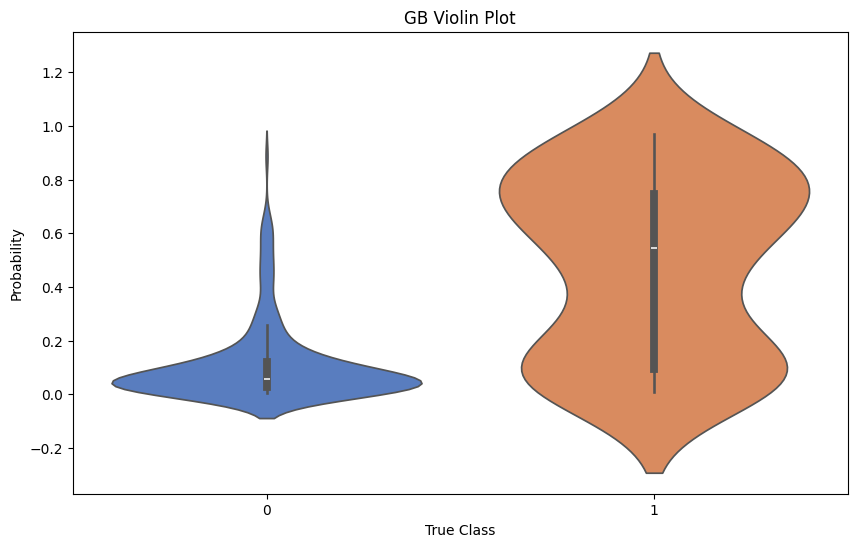

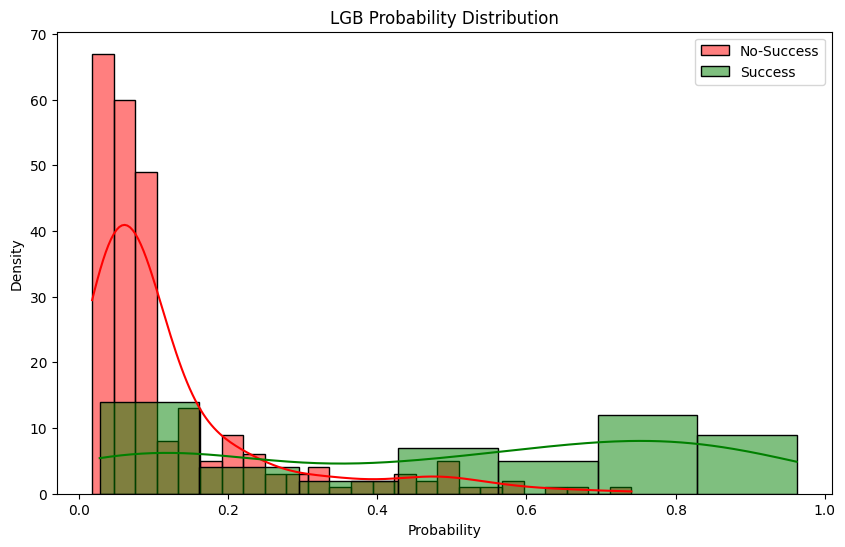

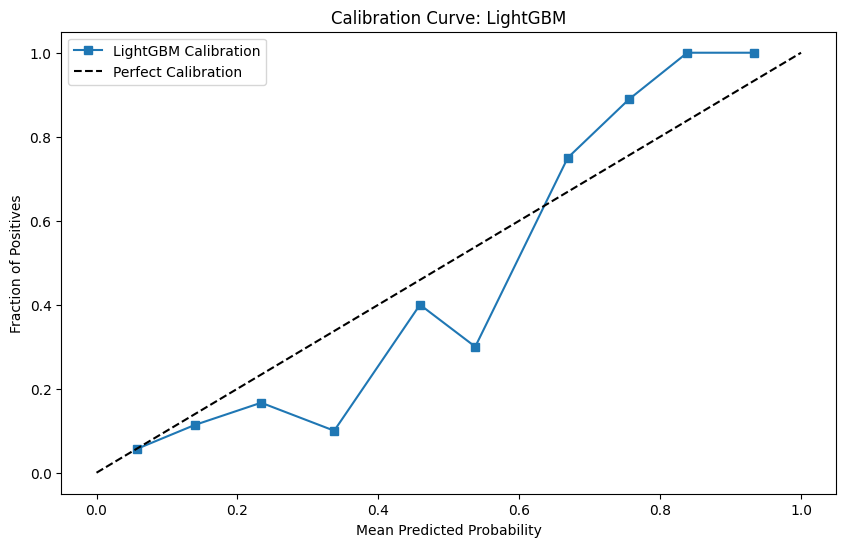

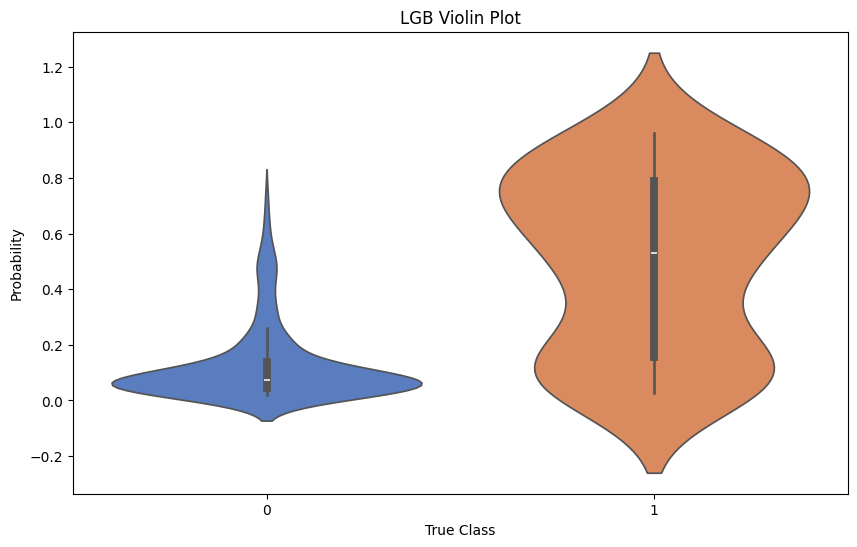

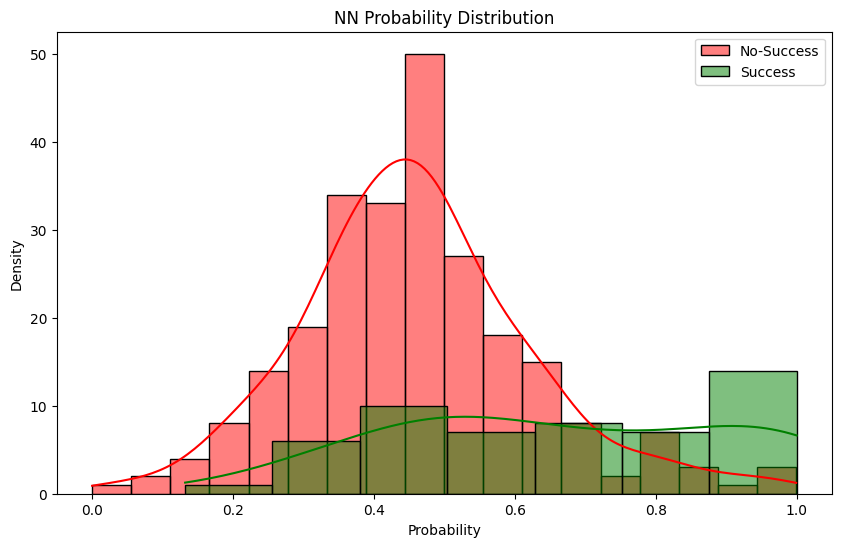

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


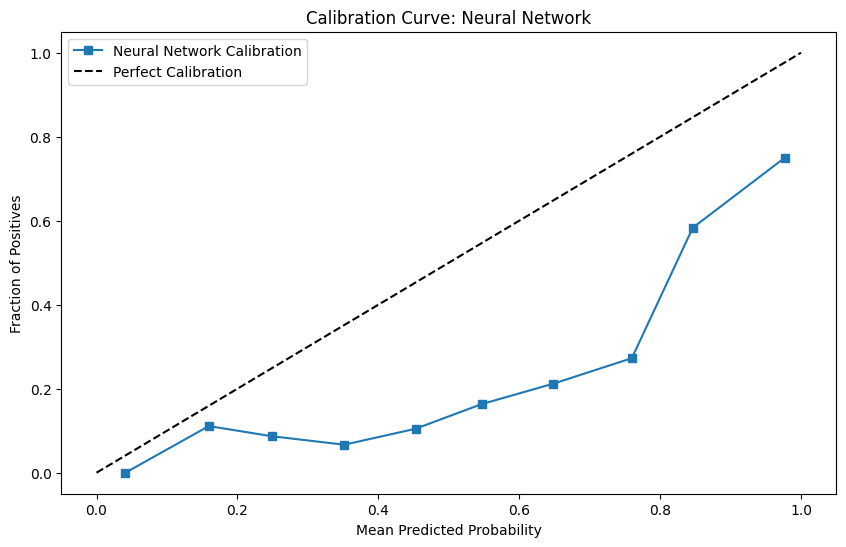

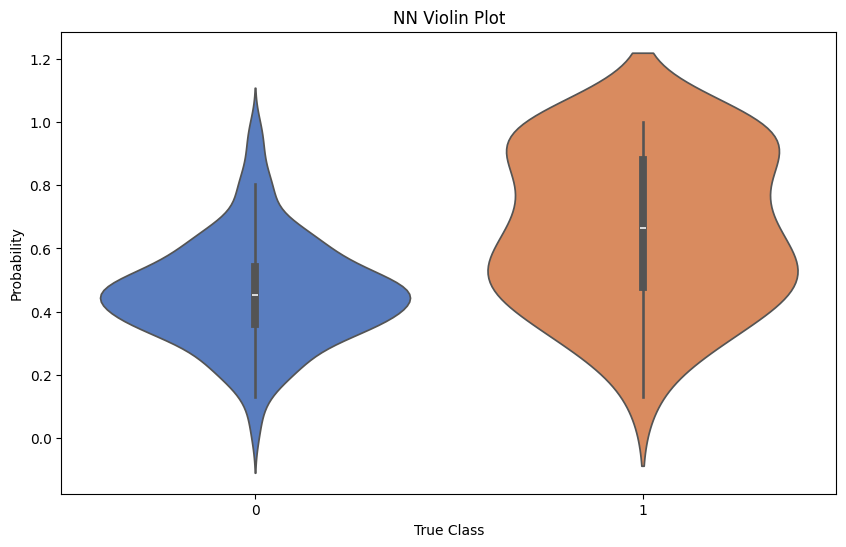

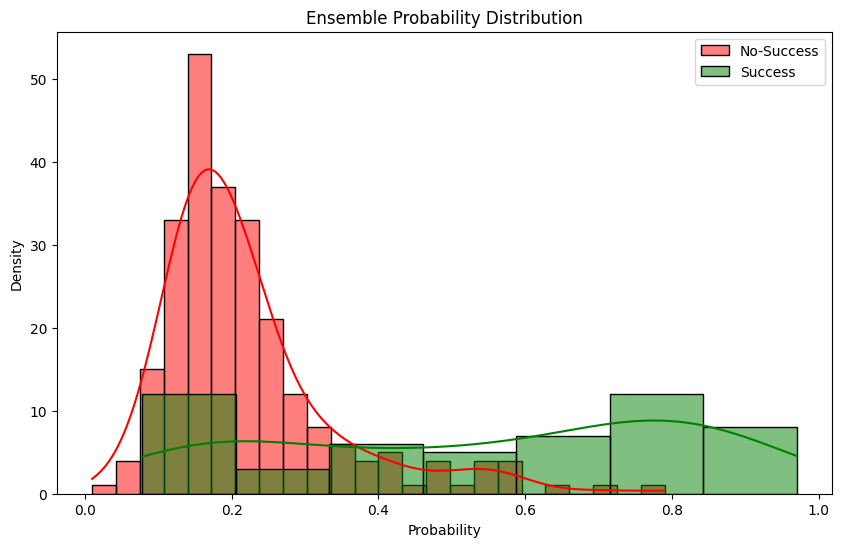

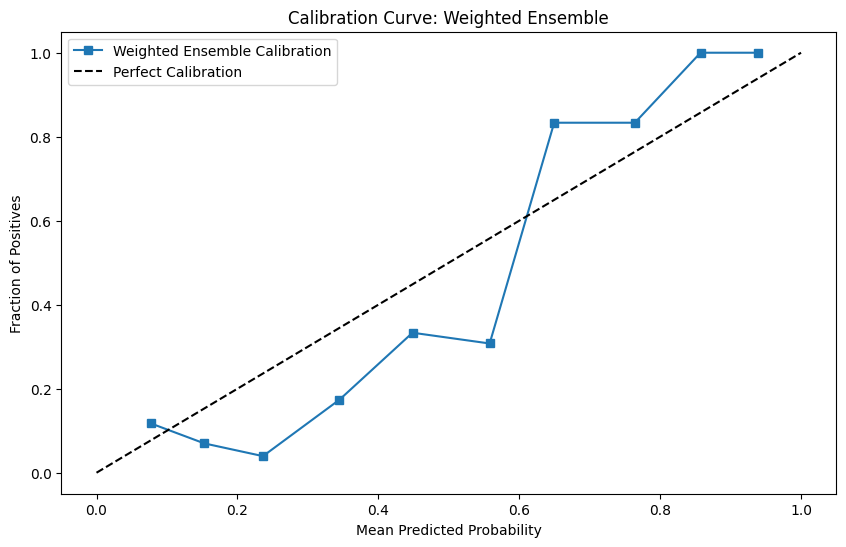

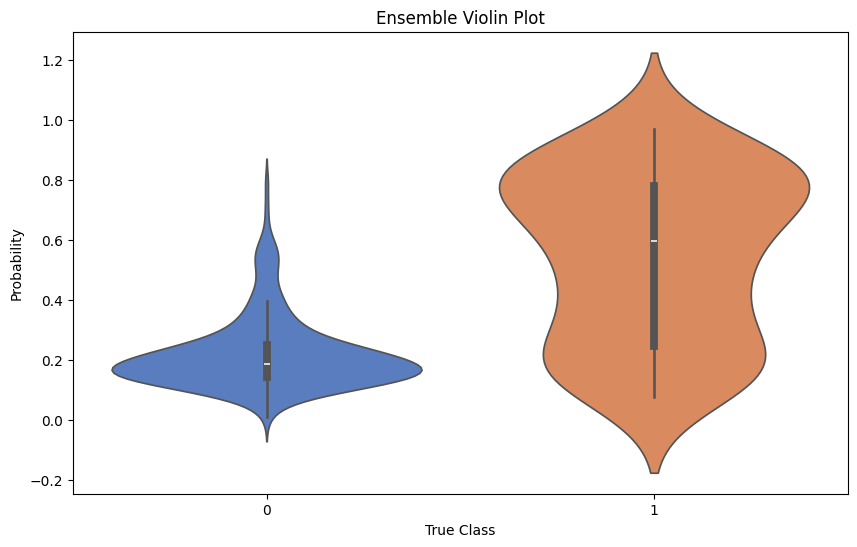

In [58]:
def probability_distribution_plot(df, model_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[df["True Class (Test)"] == 0][f"{model_name} Probability (Success, Test)"], color="red", label="No-Success", kde=True)
    sns.histplot(df[df["True Class (Test)"] == 1][f"{model_name} Probability (Success, Test)"], color="green", label="Success", kde=True)
    plt.title(f"{model_name} Probability Distribution")
    plt.xlabel("Probability")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

def calibration_curve_plot(model, X, y, model_name, is_nn=False, is_ensemble=False):
    if is_nn:
        probs = model.predict(X).ravel()
    elif is_ensemble:
        probs = model
    else:
        probs = model.predict_proba(X)[:, 1]
    prob_true, prob_pred = calibration_curve(y, probs, n_bins=10)
    plt.figure(figsize=(10, 6))
    plt.plot(prob_pred, prob_true, "s-", label=f"{model_name} Calibration")
    plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
    plt.title(f"Calibration Curve: {model_name}")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.legend()
    plt.show()

# Violin Plot
def violin_plot(df, model_name):
    plt.figure(figsize=(10, 6))
    sns.violinplot(x="True Class (Test)", y=f"{model_name} Probability (Success, Test)", data=df, palette="muted")
    plt.title(f"{model_name} Violin Plot")
    plt.xlabel("True Class")
    plt.ylabel("Probability")
    plt.show()

# Gradient Boosting
probability_distribution_plot(test_results, "GB")
calibration_curve_plot(best_gb_model, X_test_scaled, y_test, "Gradient Boosting")
violin_plot(test_results, "GB")

# LightGBM
probability_distribution_plot(test_results, "LGB")
calibration_curve_plot(best_lgb_model, X_test_scaled, y_test, "LightGBM")
violin_plot(test_results, "LGB")

# Neural Network
probability_distribution_plot(test_results, "NN")
calibration_curve_plot(nn_model, X_test_scaled, y_test, "Neural Network", is_nn=True)
violin_plot(test_results, "NN")

# Weighted Ensemble
probability_distribution_plot(test_results, "Ensemble")
calibration_curve_plot(ensemble_test_probabilities, X_test_scaled, y_test, "Weighted Ensemble", is_ensemble=True)
violin_plot(test_results, "Ensemble")


## Feature Importance

### SHAP-values

In [59]:
def shap_analysis_top_features_save(model, X_train, X_test, feature_names, top_n=7, output_dir="./", label_size=10):
    import os
    try:
        os.makedirs(output_dir, exist_ok=True)

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        mean_abs_shap_values = pd.DataFrame({
            'Feature': feature_names,
            'MeanAbsSHAP': abs(shap_values).mean(axis=0)
        }).sort_values(by='MeanAbsSHAP', ascending=False)

        top_features = mean_abs_shap_values.head(top_n)['Feature'].values
        X_test_top = pd.DataFrame(X_test, columns=feature_names)[top_features]

        feature_indices = [list(feature_names).index(feature) for feature in top_features]
        shap_values_top = shap_values[:, feature_indices]

        summary_plot_path = os.path.join(output_dir, f"{model.__class__.__name__}_SHAP_Summary_Top{top_n}.png")
        shap.summary_plot(shap_values_top, X_test_top, feature_names=top_features, show=False)
        plt.gca().tick_params(labelsize=label_size)

        plt.savefig(summary_plot_path, bbox_inches='tight')
        plt.close()
        print(f"Saved SHAP Summary Plot to {summary_plot_path}")

        bar_plot_path = os.path.join(output_dir, f"{model.__class__.__name__}_SHAP_Bar_Top{top_n}.png")
        shap.summary_plot(shap_values_top, X_test_top, feature_names=top_features, plot_type="bar", show=False)
        plt.gca().tick_params(labelsize=label_size)

        plt.savefig(bar_plot_path, bbox_inches='tight')
        plt.close()
        print(f"Saved SHAP Bar Plot to {bar_plot_path}")

        return shap_values_top, top_features
    except Exception as e:
        print(f"Error in SHAP analysis: {e}")
        return None, None

output_directory = r"\Users\ssmer\OneDrive\Desktop\Studium\Master\3 Semester\Advanced Data Analytics for Business\clone\PredictingVentureSuccess_ADA-main - Kopie\PredictingVentureSuccess_ADA-main\Code\Modelling_final - neue data - Kopie" 

print("Analyzing Gradient Boosting Model...")
gb_shap_values_top, gb_top_features = shap_analysis_top_features_save(
    best_gb_model, X_train_scaled, X_test_scaled, X.columns, top_n=7, output_dir=output_directory, label_size=10
)

print("Analyzing LightGBM Model...")
lgb_shap_values_top, lgb_top_features = shap_analysis_top_features_save(
    best_lgb_model, X_train_scaled, X_test_scaled, X.columns, top_n=7, output_dir=output_directory, label_size=10
)

Analyzing Gradient Boosting Model...
Saved SHAP Summary Plot to \Users\ssmer\OneDrive\Desktop\Studium\Master\3 Semester\Advanced Data Analytics for Business\clone\PredictingVentureSuccess_ADA-main - Kopie\PredictingVentureSuccess_ADA-main\Code\Modelling_final - neue data - Kopie\GradientBoostingClassifier_SHAP_Summary_Top7.png
Saved SHAP Bar Plot to \Users\ssmer\OneDrive\Desktop\Studium\Master\3 Semester\Advanced Data Analytics for Business\clone\PredictingVentureSuccess_ADA-main - Kopie\PredictingVentureSuccess_ADA-main\Code\Modelling_final - neue data - Kopie\GradientBoostingClassifier_SHAP_Bar_Top7.png
Analyzing LightGBM Model...
Saved SHAP Summary Plot to \Users\ssmer\OneDrive\Desktop\Studium\Master\3 Semester\Advanced Data Analytics for Business\clone\PredictingVentureSuccess_ADA-main - Kopie\PredictingVentureSuccess_ADA-main\Code\Modelling_final - neue data - Kopie\LGBMClassifier_SHAP_Summary_Top7.png
Saved SHAP Bar Plot to \Users\ssmer\OneDrive\Desktop\Studium\Master\3 Semester\

## Dashboard Preparation (Data to JSON)

In [60]:
def prepare_dashboard_data(test_results, feature_names,
                           gb_shap_values, lgb_shap_values,
                           ensemble_test_predictions, ensemble_test_probabilities):
    from sklearn.metrics import confusion_matrix, classification_report
    import numpy as np
    import pandas as pd
    import json

    def prepare_confusion_matrix_section(true_class, predicted_class):
        tn, fp, fn, tp = confusion_matrix(true_class, predicted_class).ravel()
        return {
            "truePositive": int(tp),
            "trueNegative": int(tn),
            "falsePositive": int(fp),
            "falseNegative": int(fn)
        }

    def transform_results(results, prediction_column, probability_column):
        transformed = []
        for _, row in results.iterrows():
            transformed.append({
                "id": row["ID"],
                "actualLabel": "Positive" if row["True Class (Test)"] == 1 else "Negative",
                "predictedLabel": "Positive" if row[prediction_column] == 1 else "Negative",
                "confidence": f"{row[probability_column] * 100:.2f}%",
                "timestamp": pd.Timestamp.now().isoformat()
            })
        return transformed

    def transform_results_ensemble(true_class, predictions, probabilities, observation_ids):
        transformed = []
        for obs_id, actual, pred, prob in zip(observation_ids, true_class, predictions, probabilities):
            transformed.append({
                "id": obs_id,
                "actualLabel": "Positive" if actual == 1 else "Negative",
                "predictedLabel": "Positive" if pred == 1 else "Negative",
                "confidence": f"{prob * 100:.2f}%",
                "timestamp": pd.Timestamp.now().isoformat()
            })
        return transformed

    def format_shap_values(shap_values, feature_names):
        shap_formatted = [
            {"feature": feature, "value": float(shap_value)}
            for feature, shap_value in zip(feature_names, np.abs(shap_values).mean(axis=0))
        ]
        return shap_formatted

    gb_shap_data = format_shap_values(gb_shap_values, feature_names)
    lgb_shap_data = format_shap_values(lgb_shap_values, feature_names)

    gb_data = {
        "name": "Gradient Boosting",
        "stats": {
            "accuracy": (test_results['True Class (Test)'] == test_results['GB Prediction (Test)']).mean(),
            "precision": classification_report(
                test_results['True Class (Test)'],
                test_results['GB Prediction (Test)'],
                output_dict=True
            )['macro avg']['precision'],
            "recall": classification_report(
                test_results['True Class (Test)'],
                test_results['GB Prediction (Test)'],
                output_dict=True
            )['macro avg']['recall'],
            "f1Score": classification_report(
                test_results['True Class (Test)'],
                test_results['GB Prediction (Test)'],
                output_dict=True
            )['macro avg']['f1-score']
        },
        "confusionMatrix": prepare_confusion_matrix_section(
            test_results['True Class (Test)'],
            test_results['GB Prediction (Test)']
        ),
        "results": transform_results(
            test_results, "GB Prediction (Test)", "GB Probability (Success, Test)"
        ),
        "shapValues": gb_shap_data,
        "paperUrl": "https://arxiv.org/abs/1603.02754"
    }

    lgb_data = {
        "name": "LightGBM",
        "stats": {
            "accuracy": (test_results['True Class (Test)'] == test_results['LGB Prediction (Test)']).mean(),
            "precision": classification_report(
                test_results['True Class (Test)'],
                test_results['LGB Prediction (Test)'],
                output_dict=True
            )['macro avg']['precision'],
            "recall": classification_report(
                test_results['True Class (Test)'],
                test_results['LGB Prediction (Test)'],
                output_dict=True
            )['macro avg']['recall'],
            "f1Score": classification_report(
                test_results['True Class (Test)'],
                test_results['LGB Prediction (Test)'],
                output_dict=True
            )['macro avg']['f1-score']
        },
        "confusionMatrix": prepare_confusion_matrix_section(
            test_results['True Class (Test)'],
            test_results['LGB Prediction (Test)']
        ),
        "results": transform_results(
            test_results, "LGB Prediction (Test)", "LGB Probability (Success, Test)"
        ),
        "shapValues": lgb_shap_data,
        "paperUrl": "https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree"
    }

    logistic_data = {
        "name": "Logistic Regression",
        "stats": {
            "accuracy": (test_results['True Class (Test)'] == test_results['Logistic Prediction (Test)']).mean(),
            "precision": classification_report(
                test_results['True Class (Test)'],
                test_results['Logistic Prediction (Test)'],
                output_dict=True
            )['macro avg']['precision'],
            "recall": classification_report(
                test_results['True Class (Test)'],
                test_results['Logistic Prediction (Test)'],
                output_dict=True
            )['macro avg']['recall'],
            "f1Score": classification_report(
                test_results['True Class (Test)'],
                test_results['Logistic Prediction (Test)'],
                output_dict=True
            )['macro avg']['f1-score']
        },
        "confusionMatrix": prepare_confusion_matrix_section(
            test_results['True Class (Test)'],
            test_results['Logistic Prediction (Test)']
        ),
        "results": transform_results(
            test_results, "Logistic Prediction (Test)", "Logistic Probability (Success, Test)"
        ),
        "shapValues": [],
        "paperUrl": "https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html"
    }

    nn_data = {
        "name": "Neural Network",
        "stats": {
            "accuracy": (test_results['True Class (Test)'] == test_results['NN Prediction (Test)']).mean(),
            "precision": classification_report(
                test_results['True Class (Test)'],
                test_results['NN Prediction (Test)'],
                output_dict=True
            )['macro avg']['precision'],
            "recall": classification_report(
                test_results['True Class (Test)'],
                test_results['NN Prediction (Test)'],
                output_dict=True
            )['macro avg']['recall'],
            "f1Score": classification_report(
                test_results['True Class (Test)'],
                test_results['NN Prediction (Test)'],
                output_dict=True
            )['macro avg']['f1-score']
        },
        "confusionMatrix": prepare_confusion_matrix_section(
            test_results['True Class (Test)'],
            test_results['NN Prediction (Test)']
        ),
        "results": transform_results(
            test_results, "NN Prediction (Test)", "NN Probability (Success, Test)"
        ),
        "shapValues": [],
        "paperUrl": "https://arxiv.org/abs/1512.03385"
    }
    
    tabpfn_data = {
        "name": "TabPFN",
        "stats": {
            "accuracy": (test_results['True Class (Test)'] == test_results['TabPFN Prediction (Test)']).mean(),
            "precision": classification_report(
                test_results['True Class (Test)'],
                test_results['TabPFN Prediction (Test)'],
                output_dict=True
            )['macro avg']['precision'],
            "recall": classification_report(
                test_results['True Class (Test)'],
                test_results['TabPFN Prediction (Test)'],
                output_dict=True
            )['macro avg']['recall'],
            "f1Score": classification_report(
                test_results['True Class (Test)'],
                test_results['TabPFN Prediction (Test)'],
                output_dict=True
            )['macro avg']['f1-score']
        },
        "confusionMatrix": prepare_confusion_matrix_section(
            test_results['True Class (Test)'],
            test_results['TabPFN Prediction (Test)']
        ),
        "results": transform_results(
            test_results, "TabPFN Prediction (Test)", "TabPFN Probability (Success, Test)"
        ),
        "shapValues": [],
        "paperUrl": "https://arxiv.org/abs/1512.03385"
    }


    true_classes = test_results['True Class (Test)']
    ensemble_data = {
        "name": "Ensemble Model",
        "stats": {
            "accuracy": (true_classes == ensemble_test_predictions).mean(),
            "precision": classification_report(
                true_classes,
                ensemble_test_predictions,
                output_dict=True
            )['macro avg']['precision'],
            "recall": classification_report(
                true_classes,
                ensemble_test_predictions,
                output_dict=True
            )['macro avg']['recall'],
            "f1Score": classification_report(
                true_classes,
                ensemble_test_predictions,
                output_dict=True
            )['macro avg']['f1-score']
        },
        "confusionMatrix": prepare_confusion_matrix_section(
            true_classes,
            ensemble_test_predictions
        ),
        "results": transform_results_ensemble(
            true_classes,
            ensemble_test_predictions,
            ensemble_test_probabilities,
            test_results["Observation Index"]
        ),
        "shapValues": [],
        "paperUrl": ""
    }

    dashboard_data = [gb_data, lgb_data, logistic_data, nn_data, ensemble_data, tabpfn_data]
    with open("dashboard_data.json", "w") as f:
        json.dump(dashboard_data, f, indent=4)

    print("Dashboard data is saved under dashboard_data.json")


In [61]:
# Calling the function
prepare_dashboard_data(
    test_results=test_results,
    feature_names=X.columns,
    gb_shap_values=gb_shap_values_top,
    lgb_shap_values=lgb_shap_values_top,
    ensemble_test_predictions=ensemble_test_predictions,
    ensemble_test_probabilities=ensemble_test_probabilities
)

Dashboard data is saved under dashboard_data.json
